In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:
# Chargement des données
data = pd.read_csv("data/data.csv")
data_clean = pd.read_csv("data/data.csv")

# Affichage des premières lignes
data.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [3]:
# Vérification des valeurs manquantes
missing_per_column = data.isnull().sum()
total_missing_values = missing_per_column.sum()

print(f"Nombre total de valeurs manquantes : {total_missing_values}")
missing_per_column

Nombre total de valeurs manquantes : 6826


Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

In [4]:
# Remplacement des valeurs manquantes
numerical_cols = data_clean.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data_clean.select_dtypes(include=['object', 'category']).columns

for col in numerical_cols:
    data_clean[col].fillna(data_clean[col].median(), inplace=True)

for col in categorical_cols:
    mode_value = data_clean[col].mode()[0]
    data_clean[col].fillna(mode_value, inplace=True)

# Vérification après traitement
data_clean.isnull().sum()

/var/folders/t7/rp7vj46901x_qv9fzp32j1800000gn/T/ipykernel_5988/1944209824.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_clean[col].fillna(mode_value, inplace=True)


Transaction ID      0
Item                0
Quantity            0
Price Per Unit      0
Total Spent         0
Payment Method      0
Location            0
Transaction Date    0
dtype: int64

In [5]:
# Encodage des variables catégorielles
label_encoders = {}

for col in ['Item', 'Payment Method', 'Location']:
    le = LabelEncoder()
    data_clean[col] = le.fit_transform(data_clean[col])
    label_encoders[col] = le

data_clean.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,1,2,2.0,4.0,1,2,2023-09-08
1,TXN_4977031,0,4,3.0,12.0,0,1,2023-05-16
2,TXN_4271903,2,4,1.0,ERROR,1,1,2023-07-19
3,TXN_7034554,5,2,5.0,10.0,4,3,2023-04-27
4,TXN_3160411,1,2,2.0,4.0,2,1,2023-06-11


In [6]:
# Correction des types de données
numerical_cols = ['Quantity', 'Price Per Unit', 'Total Spent', 'Item', 'Payment Method', 'Location']
categorical_cols = ['Transaction ID']
date_cols = ['Transaction Date']

for col in numerical_cols:
    data_clean[col] = pd.to_numeric(data_clean[col], errors='coerce')

for col in categorical_cols:
    data_clean[col] = data_clean[col].astype('category')

for col in date_cols:
    data_clean[col] = pd.to_datetime(data_clean[col], errors='coerce')

# Suppression des dates invalides
data_clean = data_clean.dropna(subset=date_cols)

# Vérification des types
data_clean.dtypes

Transaction ID            category
Item                         int64
Quantity                   float64
Price Per Unit             float64
Total Spent                float64
Payment Method               int64
Location                     int64
Transaction Date    datetime64[ns]
dtype: object

In [7]:
# Affichage des statistiques descriptives
data_clean.describe()

,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,9540.000000,9221.000000,9199.000000,9221.000000,9540.000000,9540.000000,9540
mean,4.219706,3.054224,2.950919,8.864819,1.409853,1.661006,2023-07-01 23:00:31.698113536
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2023-01-01 00:00:00
25%,2.000000,2.000000,2.000000,4.000000,1.000000,1.000000,2023-04-01 00:00:00
50%,4.000000,3.000000,3.000000,7.500000,2.000000,2.000000,2023-07-02 00:00:00
75%,7.000000,4.000000,4.000000,12.000000,2.000000,2.000000,2023-10-02 00:00:00
max,9.000000,5.000000,5.000000,25.000000,4.000000,3.000000,2023-12-31 00:00:00
std,2.725701,1.427757,1.266255,5.970837,0.965680,0.602237,NaN


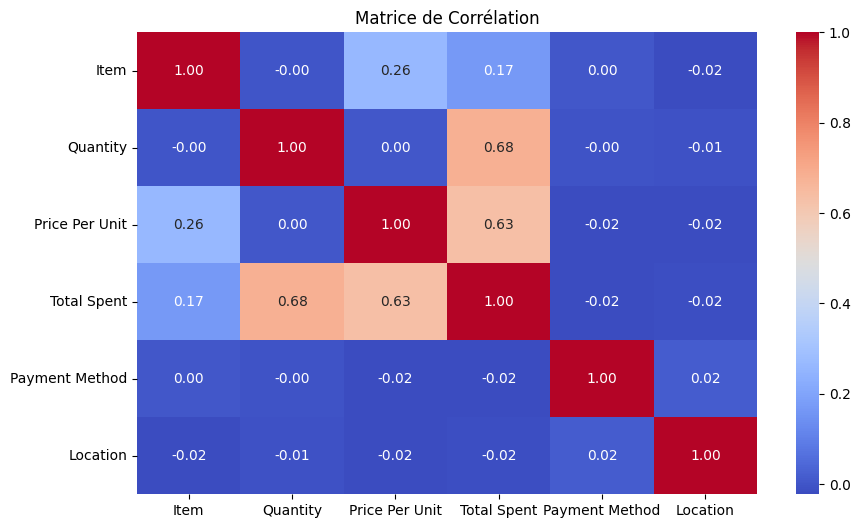

In [9]:
# Sélectionner uniquement les colonnes numériques
numeric_data = data_clean.select_dtypes(include=['number'])

# Matrice de corrélation
plt.figure(figsize=(10,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de Corrélation")
plt.show()

/var/folders/t7/rp7vj46901x_qv9fzp32j1800000gn/T/ipykernel_5988/4209336312.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=item_counts.index, y=item_counts.values, palette="viridis")
/Users/hibarahilsoussah/Desktop/vscode/CoffeShop/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


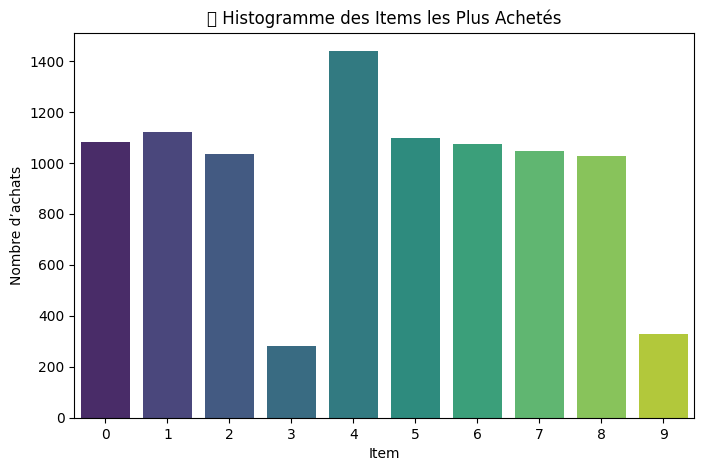

In [10]:
# Histogramme des items les plus achetés
item_counts = data_clean['Item'].value_counts()

plt.figure(figsize=(8,5))
sns.barplot(x=item_counts.index, y=item_counts.values, palette="viridis")
plt.xlabel("Item")
plt.ylabel("Nombre d’achats")
plt.title("📌 Histogramme des Items les Plus Achetés")
plt.show()

/var/folders/t7/rp7vj46901x_qv9fzp32j1800000gn/T/ipykernel_5988/2538043300.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=payment_counts.index, y=payment_counts.values, palette="muted")
/Users/hibarahilsoussah/Desktop/vscode/CoffeShop/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


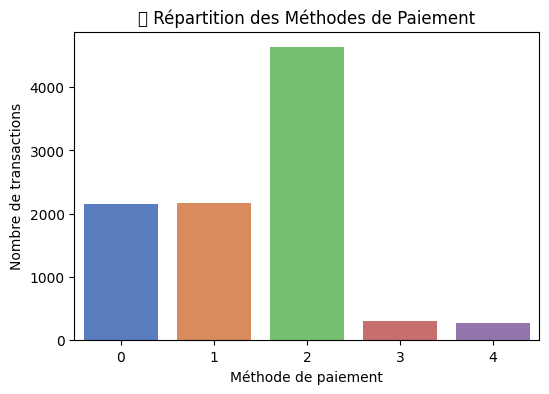

In [11]:
# Distribution des méthodes de paiement
payment_counts = data_clean['Payment Method'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=payment_counts.index, y=payment_counts.values, palette="muted")
plt.xlabel("Méthode de paiement")
plt.ylabel("Nombre de transactions")
plt.title("📌 Répartition des Méthodes de Paiement")
plt.show()

# Synthèse & Conclusion
Grâce à cette analyse, nous avons pu :
- Nettoyer et préparer les données
- Vérifier et traiter les valeurs manquantes
- Analyser les relations entre variables avec une matrice de corrélation
- Visualiser les tendances des achats et des méthodes de paiement

Ce notebook offre une base solide pour des analyses plus poussées sur les ventes du coffee shop !